In [26]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as pt
import yfinance as yf
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Theory: The ARIMA Model

ARIMA stands for AutoRegressive Integrated Moving Average, a popular statistical method used for forecasting time series data (data collected over time in sequence, like stock prices, weather, etc.).

### 1. Components of $\fbox{ARIMA}$:

- $\fbox{AR (AutoRegressive)}$: This part involves using the $\textcolor{red}{\text{past values}}$ to predict $\textcolor{green}{\text{future values}}$.

- $\fbox{I (Integrated)}$: This refers to $\textcolor{red}{\text{differencing}}$ the time series to make it $\textbf{stationary}$. A time series is stationary if its statistical properties like mean, variance and autocorrelation are constant over time. Many time series, like stock prices, have trens, so they are non-stationary and need to be mae stationary before modeling.

- $\fbox{MA (Moving Average)}$: This part models the $\textcolor{red}{\text{error term as}}$ $\textcolor{red}{\text{a linear combination of}}$ $\textcolor{red}{\text{past error terms}}$. The model looks at the past forecast errors (differences between actual and predicted values) to make predictions.

### 2. Understanding ARIMA through an Example: Stock Price Prediction

Let’s break it down in an example where we forecast daily stock prices for a company using ARIMA.


#### $\fbox{Step 1: Autoregression (AR)}$

The $\textcolor{red}{\text{AR}}$ component $\textcolor{red}{\text{tries to predict a value based on its previous values}}$.

Example:

- You have daily stock prices, and you want to predict today’s stock price. The model might use yesterday's and the day before's prices to predict today's.
  
Mathematically, if you choose an $\textcolor{blue}{\text{AR(1) model}}$, the relationship could be:

$$
\large X\_t = c + \phi_1 X_{t-1} + \epsilon_t
$$


Where:
- $X_t$ = today's stock price
- $X_{t-1}$ = yesterday’s stock price
- $\phi_1$ = coefficient of lag-1 price (determined by the model)
- $c$ = constant
- $\epsilon_t$ = white noise (error term)

#### $\fbox{Step 2: Integrated (I)}$

Real-world time series data often have a $\textcolor{red}{\text{trend}}$ (increasing or decreasing over time), making them non-stationary. $\textcolor{red}{\text{To apply ARIMA, we need to make the data stationary}}$.

$\textcolor{blue}{\text{Differencing}}$ is a technique to remove trends and achieve stationarity by subtracting each data point from its previous value.

- Example:
  - Original time series: 10, 12, 14, 16 (a clear upward trend)
  - After differencing: 12 - 10 = 2, 14 - 12 = 2, 16 - 14 = 2
  - The differenced series: 2, 2, 2 is stationary because there is no trend anymore.

#### $\fbox{Step 3: Moving Average (MA)}$

The $\textcolor{red}{\text{MA}}$ component $\textcolor{red}{\text{models the error (residual) between the predicted and actual value at a given point}}$ in time. Instead of using past values like AR, it $\textcolor{blue}{\text{uses past forecast errors}}$ to predict future values.

Example:
- You made a prediction yesterday, but there was an error (the actual stock price was $2 higher than your prediction).
- The model uses this error to improve today’s prediction.

Mathematically, if you choose an $\textcolor{blue}{\text{MA(1) model}}$, the relationship could be:

$$
\large X_t = \mu + \theta_1 \epsilon_{t-1} + \epsilon_t
$$

Where:
- $X_t$ = today’s stock price
- $\mu$ = mean of the series
- $\epsilon_{t-1}$ = error term from yesterday’s prediction
- $\theta_1$ = coefficient for the error
- $\epsilon_t$ = white noise

#### $\fbox{ARIMA Parameters: (p, d, q)}$

An ARIMA model is usually denoted as $\textcolor{red}{\text{ARIMA(p, d, q)}}$:
- p: the number of lag observations (for the AR part)
- d: the degree of differencing (for the I part)
- q: the size of the moving average window (for the MA part)

Let’s understand these with an example:

- **p (AutoRegression part)**: How many past observations should the model consider?
  - Example: AR(2) would use the past 2 stock prices to predict the next.

- **d (Integration part)**: How many times should we difference the series to make it stationary?
  - Example: If your data has a linear trend, you might need to difference it once (d=1).

- **q (Moving Average part)**: How many past forecast errors should the model use?
  - Example: MA(1) would use the last prediction’s error to improve the next prediction.

# 1. Downloading the Data:

GS refers to the stock ticker symbol for Goldman Sachs Group, Inc., a leading global investment banking, securities, and investment management firm.

Key Information About Goldman Sachs:
- Ticker Symbol: GS
- Exchange: New York Stock Exchange (NYSE)
- Industry: Financial Services
- Headquarters: New York City, New York, USA

In [27]:
gs_df = yf.download('GS')
gs_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-05-04,76.000000,77.250000,70.000000,70.375000,49.936535,22320900
1999-05-05,69.875000,69.875000,66.250000,69.125000,49.049583,7565700
1999-05-06,68.000000,69.375000,67.062500,67.937500,48.206944,2905700
1999-05-07,67.937500,74.875000,66.750000,74.125000,52.597466,4862300
1999-05-10,73.375000,73.500000,70.250000,70.687500,50.158302,2589400
...,...,...,...,...,...,...
2024-09-20,500.190002,502.049988,495.480011,498.429993,498.429993,4452600
2024-09-23,498.209991,501.399994,495.220001,497.410004,497.410004,953200
2024-09-24,497.589996,499.559998,494.100006,498.019989,498.019989,1035400


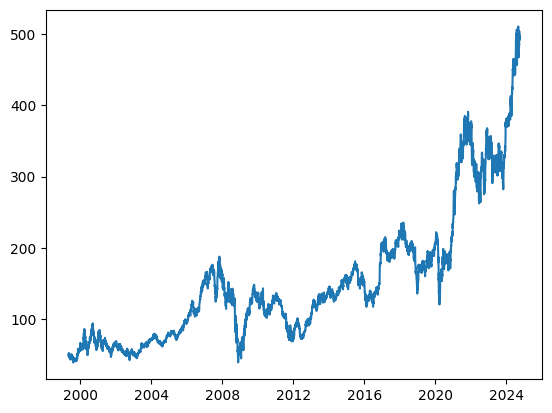

In [28]:
#Plotting obtained data 
pt.plot(gs_df.index, gs_df['Adj Close'])

# 2. Splitting Training and Testing Data

In this code snippet, we are preparing the historical data of Goldman Sachs (stored in `gs_df`) for modeling by splitting it into training and testing datasets. The split is done as follows:

- We calculate the breakpoint row by determining 90% of the total number of rows in the DataFrame gs_df. This will serve as the threshold for splitting the data.

- The len(gs_df) returns the total number of rows, and multiplying it by 0.90 gives us the number of rows to include in the training set. The int() function ensures that we have an integer value for indexing.

In [29]:
print("Original Size of Data:", gs_df.shape)

# Breaking Point
gs_break_point_row = int(len(gs_df)*0.90)

# Training Data
gs_training_data = list(gs_df[0:gs_break_point_row]['Adj Close'])
print("Size Training Data:", len(gs_training_data))

# Testing Data
gs_testing_data = list(gs_df[gs_break_point_row:]['Adj Close'])
print("Size Testing Data:",len(gs_testing_data))

Original Size of Data: (6392, 6)
Size Training Data: 5752
Size Testing Data: 640


### 2.1 Plotting Training and Testing Data

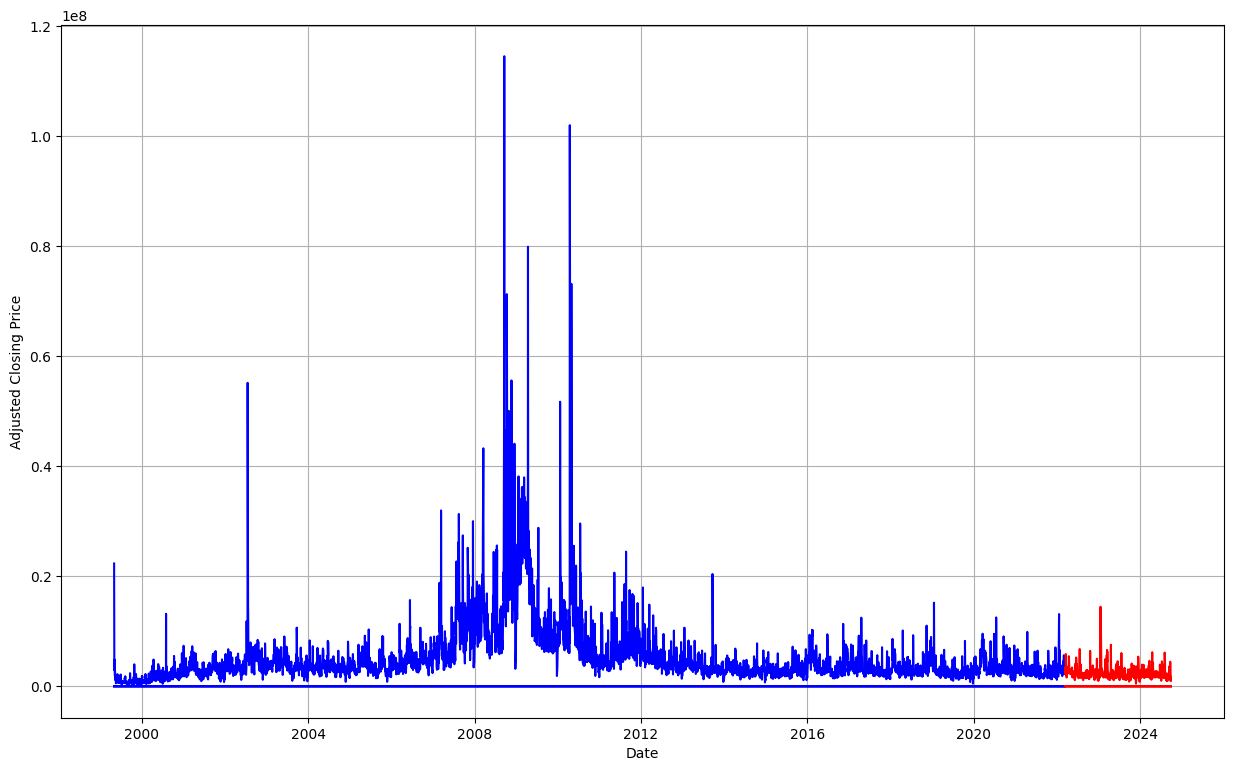

In [30]:
pt.figure(figsize=(15,9))  
pt.grid(True) 
pt.xlabel('Date')  
pt.ylabel('Adjusted Closing Price')  
pt.plot(gs_df[0:gs_break_point_row], 'blue', label = 'Testing Data')  
pt.plot(gs_df[gs_break_point_row: ], 'red', label = 'Training Data')


# 3. Create and Fit the ARIMA Model

- We will create an empty list gs_model_predictions to store the predicted values generated by the ARIMA model, such list will be of length gs_number_of_test_observations.

In [31]:
# Creating a list for all model predictions  
gs_model_predictions = []
gs_number_of_test_observations = len(gs_testing_data)

- A loop runs for each observation in the testing dataset where "i" corresponds to the current observation being processed.

- Inside the loop:
    
    $\textcolor{blue}{\text{Instantiation of the Model \& Parameters}}$: we instantiate the $\textcolor{red}{\text{ARIMA model}}$ with the training data (gs_training_data) and a specified order of (4, 1, 0):
    
    - 4 indicates the $\fbox{number of lag observations}$ included in the model (autoregressive part)
    
    - 1 stands for the $\fbox{number of times that the raw observations are differenced}$ (integrated part)

    - 0 represents the $\fbox{size of the moving average window}$ (moving average part)

    $\textcolor{blue}{\text{Forecasting \& Storing the Predictions}}$:

    - The forecast() method is called on the fitted model to make a prediction for the next time step. The output is stored in gs_model_output. This output is then converted into a list and assigned to gs_yhat.

    - The predicted value (gs_yhat) is appended to the gs_model_predictions list, accumulating all predictions made during the iterations.

    $\textcolor{blue}{\text{Updating the Training Data}}$:

    - The actual value from the testing data for the current index i is stored in gs_actual_test_value.

    - This actual value is then appended to the gs_training_data. This step is crucial because it allows the model to incorporate the latest actual observation into the training dataset for the next iteration, effectively updating the model with new information.


In [32]:
for i in tqdm(range(gs_number_of_test_observations)):
  # Instantiating the Model with its parameters
  gs_model = sm.tsa.ARIMA(gs_training_data, order=(4,1,0))
  
  # Fitting the Model
  gs_model_fit = gs_model.fit()
  
  # Forecasting the next time step
  gs_model_output = gs_model_fit.forecast()
  gs_yhat = list(gs_model_output)
  gs_model_predictions.append(gs_yhat)

  # Updating the Training Data  
  gs_actual_test_value = gs_testing_data[i]  
  gs_training_data.append(gs_actual_test_value) 
  

100%|██████████| 640/640 [01:04<00:00,  9.94it/s]


In [34]:
print("Number of Predictions:", len(gs_model_predictions))

Number of Predictions: 640


# 4. Plotting the ARIMA Prediction

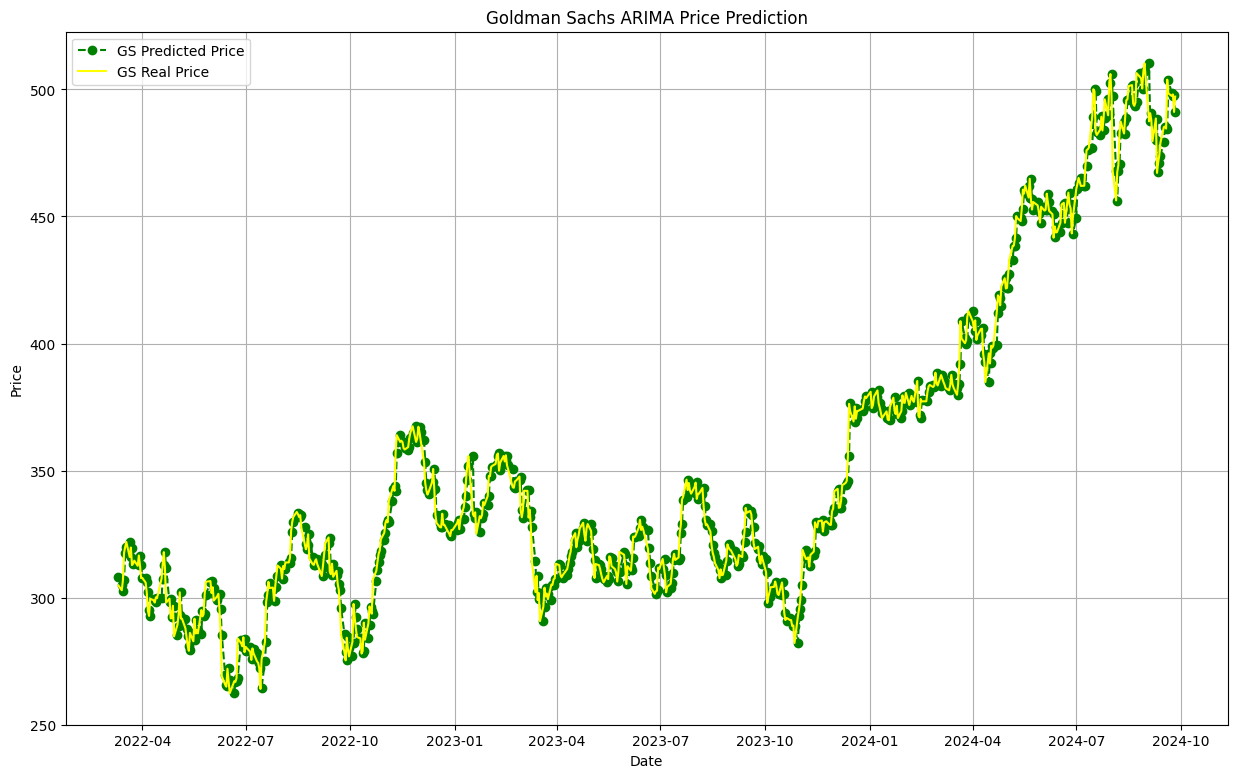

In [35]:
# Plotting ARIMA prediction  

pt.figure(figsize=(15, 9))
pt.grid(True)
date_range = gs_df[gs_break_point_row:].index  
pt.plot(date_range, gs_model_predictions, color = 'green', marker = 'o', linestyle = 'dashed', label = 'GS Predicted Price')  
pt.plot(date_range, gs_testing_data, color='yellow', label='GS Real Price')  
pt.title('Goldman Sachs ARIMA Price Prediction')  
pt.xlabel('Date')
pt.ylabel('Price')  
pt.legend()
pt.show()


In [36]:
mape = np.mean(np.abs(np.array(gs_model_predictions) - np.array(gs_testing_data))/np.abs(gs_testing_data))  
print('MAPE: ', str(mape))


MAPE:  0.1833799369718397
